<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/%EB%8B%A8%EA%B8%B0%EC%9D%B4%EB%8F%99%ED%8F%89%EA%B7%A0%EC%84%A0(MAD)_%EC%9D%B4%EA%B2%A9_%ED%99%9C%EC%9A%A9_%EC%A0%84%EB%9E%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install finance-datareader pykrx pandas_market_calendars

In [217]:
from google.colab import files
uploaded = files.upload()

Saving Daily.xlsx to Daily.xlsx


In [218]:
import pandas as pd
import FinanceDataReader as fdr
import pandas_market_calendars as mcal
from pandas.tseries.offsets import MonthEnd, BDay
from datetime import timedelta
df_daily = pd.read_excel("Daily.xlsx", sheet_name='Daily')
df_k200y = pd.read_excel("Daily.xlsx", sheet_name='K200_Y')

In [219]:
new_df_daily=df_daily.iloc[10:,2:]
new_df_daily.columns = new_df_daily.loc[10]
new_df_daily  = new_df_daily.drop(labels=[10])
new_df_daily = pd.concat([new_df_daily[['Symbol', 'Symbol Name']], new_df_daily.iloc[:,6:]], axis=1)
new_df_daily = new_df_daily.rename(columns = {'Symbol':'code', 'Symbol Name':'name'})
new_df_daily.set_index(['code', 'name'], inplace=True)
new_df_daily = new_df_daily.applymap(lambda x: float(x))

/tmp/ipython-input-2212833173.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df_daily = new_df_daily.applymap(lambda x: float(x))


In [220]:
new_df_k200y=df_k200y.iloc[10:,2:]
new_df_k200y.columns = new_df_k200y.loc[10]
new_df_k200y  = new_df_k200y.drop(labels=[10])
new_df_k200y = pd.concat([new_df_k200y[['Symbol', 'Symbol Name']], new_df_k200y.iloc[:,6:]], axis=1)
new_df_k200y = new_df_k200y.rename(columns = {'Symbol':'code', 'Symbol Name':'name'})
new_df_k200y.set_index(['code', 'name'], inplace=True)

In [221]:
ks200 = fdr.DataReader('KS200', '2016-08-22', '2025-08-22')

In [ ]:
#ks200['Change']

In [222]:
new_df_daily_reset = new_df_daily.reset_index()
# 2. `pd.melt()`를 사용하여 '와이드' 데이터를 '롱' 형태로 변환합니다.
#    id_vars에 'code'와 'name'을 지정하여 식별자로 유지합니다.
df_long = pd.melt(new_df_daily_reset, id_vars=['code', 'name'], var_name='Date', value_name='Close')

# 3. 날짜 열을 날짜 형식으로 변환하고, 데이터 정렬
df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long.sort_values(by=['code', 'Date'], inplace=True)
df_long.dropna(subset=['Close'], inplace=True)

# 4. 각 종목별(code)로 그룹을 묶어 5일, 10일 MAD 계산
df_long['MA_5'] = df_long.groupby('code')['Close'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
df_long['MAD_5'] = (df_long['Close'] - df_long['MA_5']) / df_long['MA_5']

df_long['MA_10'] = df_long.groupby('code')['Close'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)
df_long['MAD_10'] = (df_long['Close'] - df_long['MA_10']) / df_long['MA_10']

In [223]:
new_df_k200y_reset = new_df_k200y.reset_index()

df_k200_wide = pd.melt(new_df_k200y_reset, id_vars=['code', 'name'], var_name='Date', value_name='is_k200')
df_k200_wide['Date'] = pd.to_datetime(df_k200_wide['Date'])

In [224]:
df_merged = pd.merge(df_long, df_k200_wide, on=['code', 'name', 'Date'], how='left')
print("\n주가 데이터와 KOSPI 200 데이터가 병합된 DataFrame:")
print(df_merged.head())

# 4. KOSPI 200에 속한 종목(is_k200 == 'Y')만 필터링
df_k200_filtered = df_merged[df_merged['is_k200'] == 'Y'].copy()

# 5. 필터링된 데이터셋으로 MAD 재계산
df_k200_filtered['MA_10'] = df_k200_filtered.groupby('code')['Close'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)
df_k200_filtered['MAD_10'] = (df_k200_filtered['Close'] - df_k200_filtered['MA_10']) / df_k200_filtered['MA_10']


주가 데이터와 KOSPI 200 데이터가 병합된 DataFrame:
      code  name       Date   Close    MA_5     MAD_5   MA_10    MAD_10  \
0  A000020  동화약품 2016-08-22  9090.0  9090.0  0.000000  9090.0  0.000000   
1  A000020  동화약품 2016-08-23  9260.0  9175.0  0.009264  9175.0  0.009264   
2  A000020  동화약품 2016-08-24  9130.0  9160.0 -0.003275  9160.0 -0.003275   
3  A000020  동화약품 2016-08-25  9070.0  9137.5 -0.007387  9137.5 -0.007387   
4  A000020  동화약품 2016-08-26  9000.0  9110.0 -0.012075  9110.0 -0.012075   

  is_k200  
0       N  
1       N  
2       N  
3       N  
4       N  


In [225]:
# --- 월별 리밸런싱 날짜 설정 ---
monthly_rebalancing_dates = df_k200_filtered.groupby(df_k200_filtered['Date'].dt.to_period('M'))['Date'].max()

results_list = []
portfolio_list = []

for i in range(len(monthly_rebalancing_dates) - 1):
    current_date = monthly_rebalancing_dates.iloc[i]
    next_date = monthly_rebalancing_dates.iloc[i + 1]

    # 1. 리밸런싱 시점 종목 선정
    df_current_day = df_k200_filtered[df_k200_filtered['Date'] == current_date].copy()
    if df_current_day.empty:
        continue

    df_current_day.sort_values(by='MAD_10', inplace=True)
    num_stocks = len(df_current_day)
    long_codes = df_current_day['code'].head(max(1, int(num_stocks * 0.1))).tolist()
    short_codes = df_current_day['code'].tail(max(1, int(num_stocks * 0.1))).tolist()
    long_names = df_current_day['name'].head(max(1, int(num_stocks * 0.1))).tolist()
    short_names = df_current_day['name'].tail(max(1, int(num_stocks * 0.1))).tolist()

    # 2. 다음 달 전체 기간 데이터
    df_next_month = df_k200_filtered[(df_k200_filtered['Date'] > current_date) &
                                     (df_k200_filtered['Date'] <= next_date)].copy()
    if df_next_month.empty:
        continue

    # 3. 종목별 기간 수익률 계산 (agg 사용)
    long_returns = df_next_month[df_next_month['code'].isin(long_codes)].groupby('code')['Close'].agg(
        lambda x: x.iloc[-1] / x.iloc[0] - 1
    )
    short_returns = df_next_month[df_next_month['code'].isin(short_codes)].groupby('code')['Close'].agg(
        lambda x: x.iloc[0] / x.iloc[-1] - 1
    )

    # 4. 결과 저장
    results_list.append({
        'Date': current_date,
        'Long_Return': long_returns.mean(),
        'Short_Return': short_returns.mean()
    })

    # 5. 포트폴리오 구성 기록 (다음 달 전체 거래일)
    next_month_dates = df_next_month['Date'].unique()
    for d in next_month_dates:
        portfolio_list.append({
            'Date': d,
            'Long_Portfolio': long_names,
            'Short_Portfolio': short_names
        })

# --- 결과 DataFrame 생성 ---
results = pd.DataFrame(results_list)
df_portfolio = pd.DataFrame(portfolio_list)

# --- 누적 수익률 계산 ---
results.set_index('Date', inplace=True)
results['Long_Short_Return'] = results['Long_Return'] + results['Short_Return']
results['Long_Cumulative'] = (1 + results['Long_Return']).cumprod()
results['Short_Cumulative'] = (1 + results['Short_Return']).cumprod()
results['Long_Short_Cumulative'] = (1 + results['Long_Short_Return']).cumprod()

# --- 출력 ---
print("백테스트 결과 (최근 월 일부):")
print(results.tail())

백테스트 결과 (최근 월 일부):
            Long_Return  Short_Return  Long_Short_Return  Long_Cumulative  \
Date                                                                        
2025-03-31     0.014849     -0.043836          -0.028987         1.048989   
2025-04-30    -0.003739     -0.082502          -0.086241         1.045067   
2025-05-31     0.201906     -0.112390           0.089516         1.256072   
2025-06-30     0.032375      0.013491           0.045866         1.296738   
2025-07-31     0.002563     -0.016094          -0.013530         1.300061   

            Short_Cumulative  Long_Short_Cumulative  
Date                                                 
2025-03-31          3.470400               4.806482  
2025-04-30          3.184084               4.391966  
2025-05-31          2.826225               4.785117  
2025-06-30          2.864355               5.004592  
2025-07-31          2.818257               4.936878  


In [149]:
#df_portfolio.to_excel('df_portfolio.xlsx')

In [226]:
# 1. K200 월별 수익률 계산
k200_returns_list = []

ks200_reset = ks200.reset_index()

for i in range(len(monthly_rebalancing_dates) - 1):
    current_date = monthly_rebalancing_dates.iloc[i]
    next_date = monthly_rebalancing_dates.iloc[i + 1]

    # current_date 종가
    current_close_series = ks200_reset[ks200_reset['Date'] <= current_date]['Close']
    if current_close_series.empty:
        continue
    current_close = current_close_series.iloc[-1]  # 가장 가까운 이전 거래일 종가

    # next_date 종가
    next_close_series = ks200_reset[ks200_reset['Date'] <= next_date]['Close']
    if next_close_series.empty:
        continue
    next_close = next_close_series.iloc[-1]

    k200_returns_list.append({
        'Date': current_date,
        'K200_Return': next_close / current_close - 1
    })

df_k200_returns = pd.DataFrame(k200_returns_list)
df_k200_returns.set_index('Date', inplace=True)

In [ ]:
# 2. 포트폴리오 결과와 병합
comparison = results.join(df_k200_returns, how='left')

# 3. 포트폴리오 대비 K200 누적 수익률 계산
comparison['K200_Cumulative'] = (1 + comparison['K200_Return']).cumprod()
comparison['Long_vs_K200'] = comparison['Long_Cumulative'] / comparison['K200_Cumulative']
comparison['Long_Short_vs_K200'] = comparison['Long_Short_Cumulative'] / comparison['K200_Cumulative']

# 4. 결과 확인
print(comparison.tail())

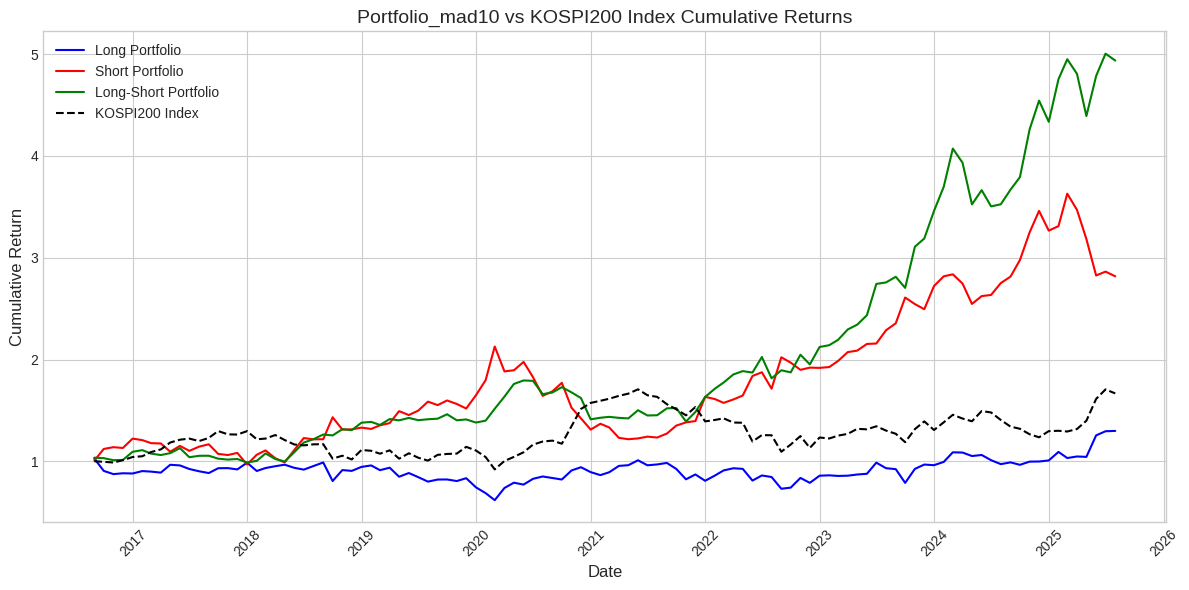

In [242]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 누적 수익률 플롯
plt.plot(comparison.index, comparison['Long_Cumulative'], label='Long Portfolio', color='blue')
plt.plot(comparison.index, comparison['Short_Cumulative'], label='Short Portfolio', color='red')
plt.plot(comparison.index, comparison['Long_Short_Cumulative'], label='Long-Short Portfolio', color='green')
plt.plot(comparison.index, comparison['K200_Cumulative'], label='KOSPI200 Index', color='black', linestyle='--')

# 제목과 라벨
plt.title('Portfolio_mad10 vs KOSPI200 Index Cumulative Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)

# 범례와 그리드
plt.legend(fontsize=10)
plt.grid(True)

# x축 날짜 표시 간격 조정 (선택)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [235]:
# Assume df_k200_filtered is already loaded and contains 'MAD_5' and 'MAD_10' columns
# df_k200_filtered = ...

# --- Backtest for MAD_5 strategy ---
results_list_mad5 = []
portfolio_list_mad5 = []

for i in range(len(monthly_rebalancing_dates) - 1):
    current_date = monthly_rebalancing_dates.iloc[i]
    next_date = monthly_rebalancing_dates.iloc[i + 1]

    # 1. 리밸런싱 시점 종목 선정 (MAD_5 기준)
    df_current_day = df_k200_filtered[df_k200_filtered['Date'] == current_date].copy()
    if df_current_day.empty:
        continue

    # ----------------------------------------------------
    #  MAD_10 대신 MAD_5로 정렬
    # ----------------------------------------------------
    df_current_day.sort_values(by='MAD_5', inplace=True)
    num_stocks = len(df_current_day)
    long_codes = df_current_day['code'].head(max(1, int(num_stocks * 0.1))).tolist()
    short_codes = df_current_day['code'].tail(max(1, int(num_stocks * 0.1))).tolist()
    long_names = df_current_day['name'].head(max(1, int(num_stocks * 0.1))).tolist()
    short_names = df_current_day['name'].tail(max(1, int(num_stocks * 0.1))).tolist()

    # 2. 다음 달 전체 기간 데이터
    df_next_month = df_k200_filtered[(df_k200_filtered['Date'] > current_date) &
                                     (df_k200_filtered['Date'] <= next_date)].copy()
    if df_next_month.empty:
        continue

    # 3. 종목별 기간 수익률 계산 (agg 사용)
    long_returns = df_next_month[df_next_month['code'].isin(long_codes)].groupby('code')['Close'].agg(
        lambda x: x.iloc[-1] / x.iloc[0] - 1
    )
    short_returns = df_next_month[df_next_month['code'].isin(short_codes)].groupby('code')['Close'].agg(
        lambda x: x.iloc[0] / x.iloc[-1] - 1
    )

    # 4. 결과 저장
    # ----------------------------------------------------
    #  MAD_5 리스트에 결과 저장
    # ----------------------------------------------------
    results_list_mad5.append({
        'Date': current_date,
        'Long_Return': long_returns.mean(),
        'Short_Return': short_returns.mean()
    })

    # 5. 포트폴리오 구성 기록 (다음 달 전체 거래일)
    # ----------------------------------------------------
    #  MAD_5 포트폴리오 리스트에 기록
    # ----------------------------------------------------
    next_month_dates = df_next_month['Date'].unique()
    for d in next_month_dates:
        portfolio_list_mad5.append({
            'Date': d,
            'Long_Portfolio': long_names,
            'Short_Portfolio': short_names
        })

In [238]:
# --- 결과 DataFrame 생성 (MAD_5) ---
results_mad5 = pd.DataFrame(results_list_mad5)
df_portfolio_mad5 = pd.DataFrame(portfolio_list_mad5)
results_mad5.set_index('Date', inplace=True)
results_mad5['Long_Short_Return'] = results_mad5['Long_Return'] + results_mad5['Short_Return']
results_mad5['Long_Cumulative'] = (1 + results_mad5['Long_Return']).cumprod()
results_mad5['Short_Cumulative'] = (1 + results_mad5['Short_Return']).cumprod()
results_mad5['Long_Short_Cumulative'] = (1 + results_mad5['Long_Short_Return']).cumprod()

In [239]:
results_mad5

,Long_Return,Short_Return,Long_Short_Return,Long_Cumulative,Short_Cumulative,Long_Short_Cumulative
Date,,,,,,
2016-08-31,0.022703,0.000150,0.022853,1.022703,1.000150,1.022853
2016-09-30,-0.136806,0.025064,-0.111742,0.882791,1.025218,0.908557
2016-10-31,-0.034157,-0.011615,-0.045772,0.852638,1.013310,0.866971
2016-11-30,0.020467,-0.017495,0.002972,0.870089,0.995581,0.869547
2016-12-31,-0.002729,0.101532,0.098804,0.867715,1.096665,0.955461
...,...,...,...,...,...,...
2025-03-31,-0.003569,-0.084909,-0.088478,0.687985,3.788566,3.456390
2025-04-30,-0.022769,-0.077121,-0.099890,0.672321,3.496389,3.111132
2025-05-31,0.142192,-0.103041,0.039151,0.767919,3.136118,3.232937


In [240]:
# 2. 포트폴리오 결과와 병합
comparison_mad5 = results_mad5.join(df_k200_returns, how='left')

# 3. 포트폴리오 대비 K200 누적 수익률 계산
comparison_mad5['K200_Cumulative'] = (1 + comparison_mad5['K200_Return']).cumprod()
comparison_mad5['Long_vs_K200'] = comparison_mad5['Long_Cumulative'] / comparison_mad5['K200_Cumulative']
comparison_mad5['Long_Short_vs_K200'] = comparison_mad5['Long_Short_Cumulative'] / comparison_mad5['K200_Cumulative']

# 4. 결과 확인
print(comparison_mad5.tail())

            Long_Return  Short_Return  Long_Short_Return  Long_Cumulative  \
Date                                                                        
2025-03-31    -0.003569     -0.084909          -0.088478         0.687985   
2025-04-30    -0.022769     -0.077121          -0.099890         0.672321   
2025-05-31     0.142192     -0.103041           0.039151         0.767919   
2025-06-30     0.025374      0.014242           0.039616         0.787404   
2025-07-31    -0.007746      0.009246           0.001500         0.781305   

            Short_Cumulative  Long_Short_Cumulative  K200_Return  \
Date                                                               
2025-03-31          3.788566               3.456390     0.019073   
2025-04-30          3.496389               3.111132     0.061640   
2025-05-31          3.136118               3.232937     0.152884   
2025-06-30          3.180784               3.361014     0.057887   
2025-07-31          3.210193               3.366055 

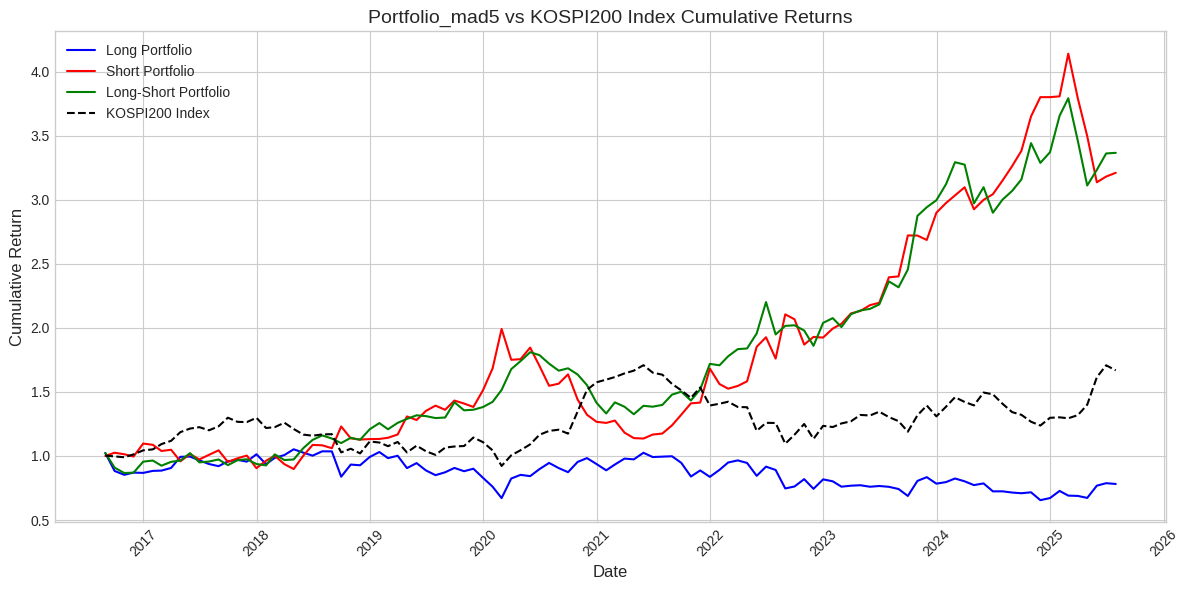

In [241]:
plt.figure(figsize=(12, 6))

# 누적 수익률 플롯
plt.plot(comparison_mad5.index, comparison_mad5['Long_Cumulative'], label='Long Portfolio', color='blue')
plt.plot(comparison_mad5.index, comparison_mad5['Short_Cumulative'], label='Short Portfolio', color='red')
plt.plot(comparison_mad5.index, comparison_mad5['Long_Short_Cumulative'], label='Long-Short Portfolio', color='green')
plt.plot(comparison_mad5.index, comparison_mad5['K200_Cumulative'], label='KOSPI200 Index', color='black', linestyle='--')

# 제목과 라벨
plt.title('Portfolio_mad5 vs KOSPI200 Index Cumulative Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)

# 범례와 그리드
plt.legend(fontsize=10)
plt.grid(True)

# x축 날짜 표시 간격 조정 (선택)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()